# Tarea 2 - Parte 2
# INF477 Redes Neuronales Artificiales I-2018

Profesor: Dr. Ricardo Ñanculef -- 
Ayudante: Francisco Mena

Alumnos:
- Jose Caimapo, jose.caimapo.12@sansano.usm.cl

- Eliana Providel Godoy, eprovide@inf.utfsm.cl

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from keras import backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import time

from collections import Counter
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout

from keras.layers import CuDNNGRU,GRU
import random,sys
from keras.callbacks import LambdaCallback


Using TensorFlow backend.


In [2]:
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

**a) Lectura de Datos y creación del dataset**

In [3]:
name = "ner.csv"

#df_ner = pd.read_csv(name, error_bad_lines=False, encoding = "ISO-8859-1")
df_ner = pd.read_csv(name, error_bad_lines=False)
df_ner.dropna(inplace=True)

print("El archivo tiene %d líneas " % len(df_ner))


Skipping line 281837: expected 25 fields, saw 34



El archivo tiene 1050794 líneas 


In [4]:
# Indexa de acuerdo a la úbicación de la etiqueta
dataset = df_ner.loc[:,["lemma","pos","tag","prev-iob"]]
dataset.index = range(len(dataset)) ## Arreglar error indices

## Ref: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus/kernels?sortBy=dateRun&group=upvoted&pageSize=20&datasetId=1014
##lemma:   lemma de un token en la oración
##pos:     Etiquetas POS de token actual
##tag:     Anotación IOB de token actual
##pre-iob: Anotación IOB token actúal

** Estructura que tiene la separación del dataset en un arreglo dataX con los arreglos de lemas, y otro arreglo dataY con los arreglos de tags.**

In [5]:
dataX,dataY = [],[]

#uniques
sentence = []
labels_sentence = []
lemmas,labels = set(), set()
for fila in dataset.values:
    if fila[-1]=="__START1__": 
        dataX.append(np.asarray(sentence))
        dataY.append(np.asarray(labels_sentence))
        sentence= []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[1])
    sentence.append(fila[0])        #add lemma
    labels_sentence.append(fila[1]) #POS o TAG
#data to  array
dataX = np.asarray(dataX[1:])
dataY = np.asarray(dataY[1:])


** ¿Porqué es conveniente utilizar lemma en vez de la palabra misma word? **

Lemma corresponde a la raíz de la palabra o forma morfológica más simple, las que tienen derivaciones como una palabra.

Es conveniente ya que de un mismo modo se pueden representar distintas palabras, disminuyendo así el tamaño  del vocabulario favoreciendo el tiempo de procesamiento.
Tiene el problema, que un mismo lemma puede representar palabras distintas.

** ¿Cuáles son las dimensiones de ambas estructuras? **

In [6]:
print("Dimensiones dataX")
dataX.shape
v_X = []
v_Y = []
for a in dataX:
    v_X.append(a.shape)

print("Dimensiones dataY")
dataY.shape
for a in dataY:
    v_Y.append(a.shape)
    
v_X = np.concatenate( v_X, axis=0 )
v_Y = np.concatenate( v_Y, axis=0 )

sum(map(lambda x: x[0]-x[1], zip(v_X, v_Y))) # --> implica que posicion por posicion los elementos dataX[i] y dataY[i] tienen el mismo largo


Dimensiones dataX


(48081,)

Dimensiones dataY


(48081,)

0

Ambos arreglos tienen el mismo largo. Además para cualquier posición i, los arreglos dataX[i]  y dataY[i]  son del mismo largo. 

** ¿Cada data de ejemplo tiene las mismas dimensiones que el resto?**

In [7]:
pd.DataFrame(map(lambda x: len(x), dataX)).describe()

,0
count,48081.000000
mean,21.854496
std,7.951569
min,1.000000
25%,16.000000
50%,21.000000
75%,27.000000
max,81.000000


No, de acuerdo a la estadística descriptiva de los largos de dataX, se puede ver que  las sentencias tienen distintos largos (min=1, max=81).

** b) Estudie la distribución del largo de los textos a procesar **

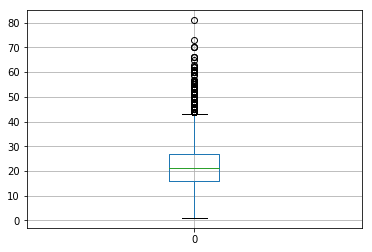

In [8]:
pd.DataFrame(map(lambda x: len(x), dataX)).boxplot()

De acuerdo a la estadística descriptiva (en punto a) y diagrama de caja, se puede observar que el 75%  de las frases tiene largo menor que 30. Los outliers tienen largo mayor a 45 aprox.

In [9]:
## Gráfico de barra para cada texto
## eje x valores de los largos de textos
## eje y cantidad de documentos con ese largo

def distribucionLargoTexto(textos):

    text_freq = []

    for a in textos:
        text_freq.append(a.shape)
        
    text_freq = np.concatenate(text_freq, axis=0 )
    counts_text = Counter(text_freq)
    
    indexes = np.arange(0, max(counts_text.items())[0]+1)
    freqs = [0] * len(indexes)

    ## Modifica las frecuencias para
    ## los items segun counts_text
    for item in counts_text.items():    
        freqs[item[0]] = item[1]

    width = 0.2
    _ = plt.figure(figsize=(15,7))
    _ = plt.bar(indexes, freqs) #, width)
    _ = plt.xticks(indexes) #, indexes)
    _ = plt.title("Distribucion del largo de los textos")   # Establece el título del gráfico
    _ = plt.xlabel("Palabras en texto")   # Establece el título del eje x 
    _ = plt.ylabel("Numero de textos")

    plt.show()


Para complementar el gráfico de caja, se presenta un gráfico de frencuencias de los largos de sentencias, donde se corrobora que no todos tienen el mismo largo.

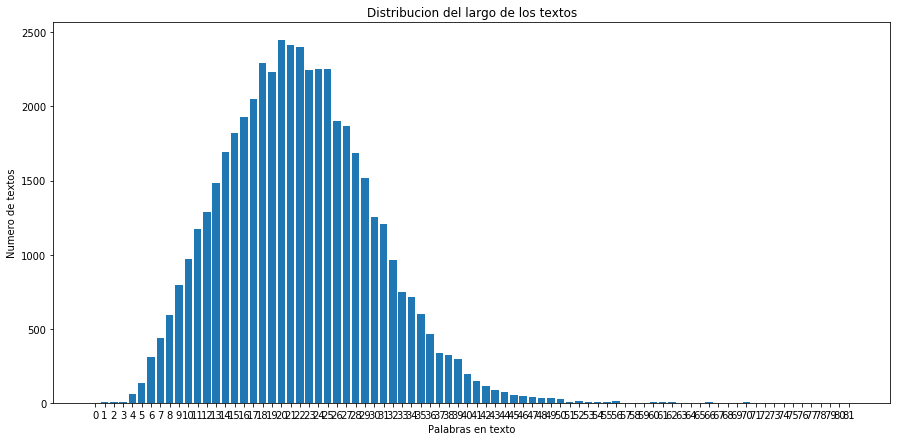

In [10]:
distribucionLargoTexto(dataX)

** Estudiar la frecuencia con las que aparecen las palabras en todo el data set, ¿Se observa una ley de Zipf? **

Para estudiar las frecuencias y determinar si existe ley de zipf de presenta un gráfico con la frecuencia de cada palabra. 

In [11]:
# Se concatenan todos los lemmas de los arreglos en un solo arreglo, para así graficar su frecuencia.
df_X = np.concatenate( dataX, axis=0 )
counts = Counter(df_X)
df_X = pd.DataFrame(df_X)

In [12]:
def distribucionPalabras(counts):
    #### graphic zipf law #### 
    labels_plot, values = zip(*counts.items())
    # sort values in descending order
    indSort = np.argsort(values)[::-1]
    # rearrange  data
    labels_plot = np.array(labels_plot)[indSort]
    values = np.array(values)[indSort]
    indexes = np.arange(len(labels_plot))
    _ = plt.plot(indexes, values)
    ax = plt.gca()
    # add labels
    #_ = plt.xticks(indexes)#, labels_plot)
    ax.set_xticklabels(['']*len(indexes))
    _ = plt.xlabel("lemmas")
    _ = plt.ylabel("frequencia")
    #_ = plt.show()    

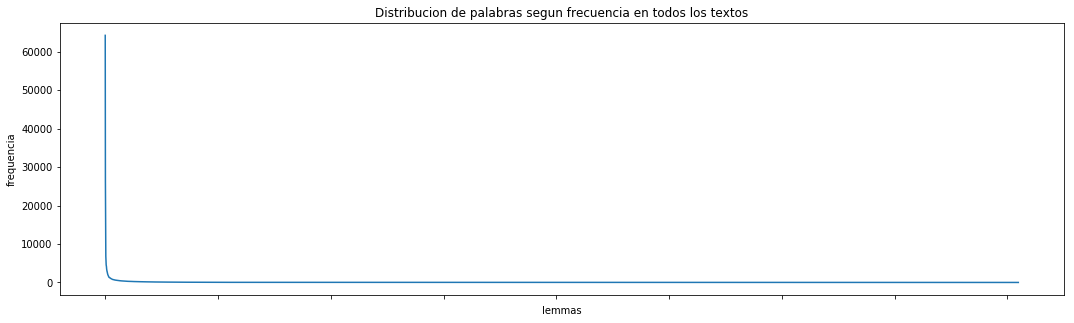

In [13]:
_ = plt.figure(figsize=(18,5))
_ = plt.title("Distribucion de palabras segun frecuencia en todos los textos") 
distribucionPalabras(counts)
_ = plt.show()

De acuerdo al gráfico, se observa que Sí existen paralabras que aparecen muchas veces y otras que aparecen pocas veces, lo que corresponde a la ley de Zipf.

** ¿Cambia el resultado cuando se separan los textos de acuerdo a su clase/categoría ? Comentar **


A continuación se gráfica por categoría la frecuencia de palabras. En el título se encuentra entre parentesís el número de palabras distintas/únicas en la categoría.

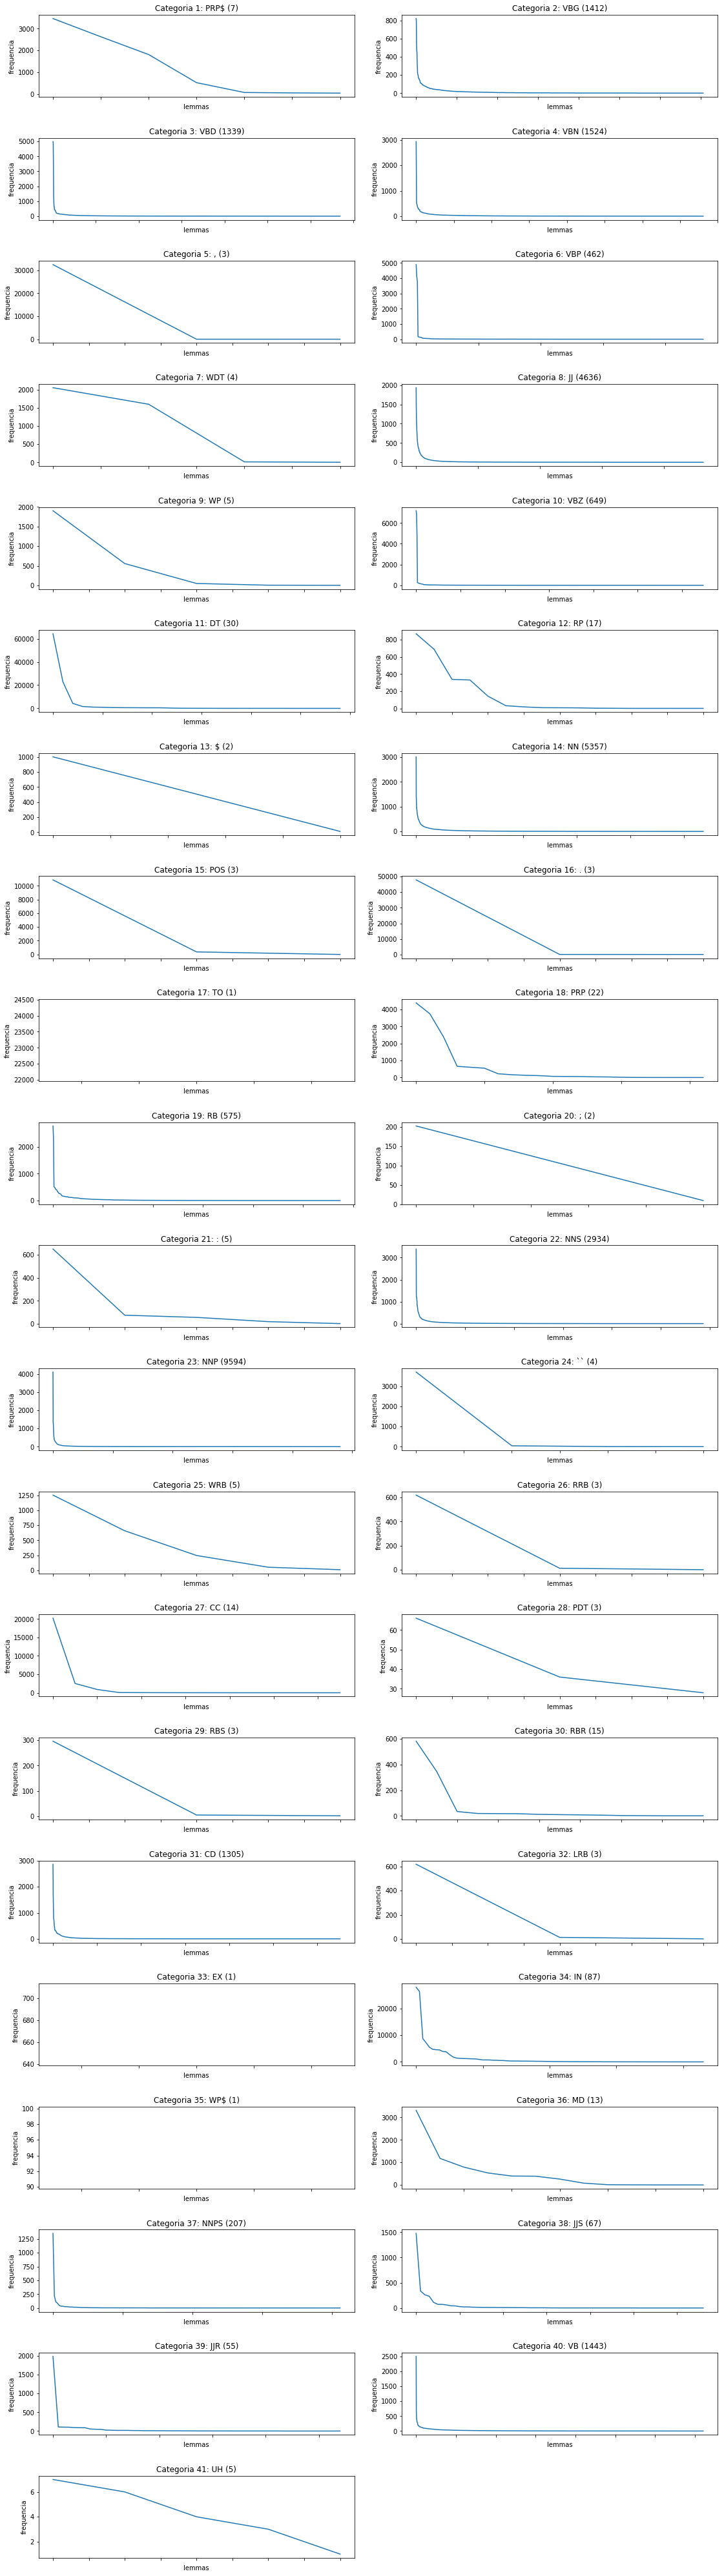

In [14]:
##
i = 1
_ = plt.close('all')
_ = plt.figure(figsize=(20,60))


## Agrupa las palabras segun su categoria, llave cat
gruposCats = dataset[['lemma', 'pos']].groupby('pos').groups
subplots_filas = (len(gruposCats)/2)+1
for cat, palabras in gruposCats.iteritems():
    _dfX = dataset.iloc[palabras.tolist()]['lemma'].tolist()
    _counts = Counter(_dfX)
    _ = plt.subplot(subplots_filas,2,i)
    _ = plt.title('Categoria %d: %s (%d)' % (i,cat, len(set(_dfX))))
    distribucionPalabras(_counts)
    i = i + 1    
_ = plt.subplots_adjust(left=0.12, bottom=0.008, right=0.85, top=0.92, wspace=0.15, hspace=0.50)
_ = plt.show()    

**Comentario**: De acuerdo a los graficos, no todos presentan la Ley de Zipf.
* Algunas categorías que sí la presentan son: VBG, VBD, JJ, VBZ, CD
* Existen categorías que se acercan al comportamiento de la ley de zipf, como es el caso de: MD, LRB
* Existen otras categorías que definitivamente no, como: UH
* También existen categorías que tienen un cantidad muy pequeña de lemmas, lo que genera gráficos que no entregan suficiente información para determinarlo, como por ejemplo TO, RRB.


### c) Codificación numérica de lemmas y tags (cada posible *lemma* a un número y cada posible *tag* a otro número)

**Enunciado**: Es necesario transformar los textos para que puedan ser entregados apropiadamente a la red, por lo será necesario crear una función que codifique cada posible *lemma* a un número y cada posible *tag* a otro número, utilice esta función sobre las sentencias y *tags* ya generados. Mida cual es el largo máximo de entre todas las sentencias, la cantidad de *lemmas* y etiquetas. Además de esto, debido al largo distinto de las sentencias se deberá realizar *padding* para estandarizar el largo, considere algun carácter especial para codificar el espacio en blanco que luego se le deberá rellenar, por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" y codificado quedará como [32,4,*0, 0*].

** Lemmas y tags a número, para que puedan ser interpretados por la red **

In [15]:
##dataX, queda codificado.
lemma2idx = {w: i for i, w in enumerate(lemmas)} #Converting text to numbers
idx2lemma = {v: k for k, v in lemma2idx.items()}
dataX = [[ lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]

In [16]:
##dataY, queda codificado
lab2idx = {t: i for i, t in enumerate(labels)}#np.concatenate(dataY, axis=0))}
idx2lab = {v: k for k, v in lab2idx.items()}
dataY = [[lab2idx[pos] for pos in pos_tags ] for pos_tags in dataY]

### Mida cual es el largo máximo de entre todas las sentencias
### Mida la cantidad de lemmas
### Mida la cantidad de etiquetas.

In [17]:
## debiesen ser iguales, como se verifico más arriba
num_maxSent = max(map(lambda x: len(x), dataX))
print("El largo máximo se arreglo de  sentencia es %d " % (num_maxSent))
num_maxTag = max(map(lambda x: len(x), dataY))
print("El largo máximo de arreglo de tag es %d" % (num_maxTag))

El largo máximo se arreglo de  sentencia es 81 
El largo máximo de arreglo de tag es 81


In [18]:
## Dado que lemmas y labels se encuentran en set(), basta con calcular len
n_lemmas = len(lemmas) ## enumerados de 0 a n_lemmas-1
n_labels = len(labels)
print("Cantidad de lemas %d"  % (n_lemmas))
print("Cantidad de labels %d" % (n_labels))

Cantidad de lemas 20243
Cantidad de labels 41


### Agrega lo necesario para padding

Se utiliza _\_ENDSEN\__ y _\_ENDTAG\__ para denotar el fin de sentencia y tag, respectivamente.

__Enunciado__: Además de esto, debido al largo distinto de las sentencias se deberá realizar *padding* para estandarizar el largo, considere algun carácter especial para codificar el espacio en blanco que luego se le deberá rellenar, por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" y codificado quedará como [32,4,*0, 0*].

In [19]:
##Agregando lemma para padding
##se utiliza: (n_lemmas +1) y (n_labels+1)
lemma2idx.update({'_ENDSEN_':len(lemmas)})
lab2idx.update({'_ENDTAG_':len(labels)})

idx2lemma.update({len(lemmas) : '_ENDSEN_'})
idx2lab.update({len(labels): '_ENDTAG_'})

##actualiza número de lemmas y tags
n_lemmas = len(lemma2idx) ## estan enumerados de 0 a n_lemmas-1
n_labels = len(lab2idx)
print("Cantidad de lemas %d"  % (n_lemmas))
print("Cantidad de labels %d" % (n_labels))

Cantidad de lemas 20244
Cantidad de labels 42


### d) Agregando el padding

In [20]:

X = sequence.pad_sequences(dataX,maxlen=num_maxSent ,padding='post',value=lemma2idx['_ENDSEN_']) 
Y = sequence.pad_sequences(dataY,maxlen=num_maxTag  ,padding='post',value=lab2idx['_ENDTAG_'])


** Comentarios:** Se agrega el padding al final, pensando que el acceso a la sentencia completa es líneal de acuerdo al largo de la sentencia original (antes del padding). En cambio si el padding es el principio siempre será necesario leer  num_maxSent elementos.

### e) Transformación de los distintos pos tagger a *one hot vector*. Queda en arreglo tridimensional con la (cantidad de ejemplos, la cantidad de palabras y la cantidad de posibles tags).

In [21]:
##Pasando a one hot vectors
Y = np.asarray([to_categorical(i, num_classes=n_labels) for i in Y])

In [22]:
#Cantidad de ejemplo (sentencias), cantidad máxima de palabras, cantidad de tags
Y.shape

(48081, 81, 42)

In [23]:
## Creando conjunto de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=22)

In [24]:
## Dimensiones
print("Dimension datos de entrenamiento - X_train %s" % str(X_train.shape))
print("Dimension datos de entrenamiento - Y_train %s" % str(Y_train.shape))
print("Dimension datos de prueba        - X_test  %s" % str(X_test.shape))
print("Dimension datos de prueba        - Y_test  %s" % str(Y_test.shape))

Dimension datos de entrenamiento - X_train (33656, 81)
Dimension datos de entrenamiento - Y_train (33656, 81, 42)
Dimension datos de prueba        - X_test  (14425, 81)
Dimension datos de prueba        - Y_test  (14425, 81, 42)


**Comentarios**: Los datos dependen del largo máximo de sentencias, que se estandarizo con el padding. 

Los _datos X_ mantienen la estructura: Cantidad de ejemplo (sentencias) y cantidad máxima de palabras, mientrás que los _datos Y_ mantienen la estrutura: Cantidad de ejemplo (sentencias), cantidad máxima de palabras, cantidad de tags.

### f) Definición de red neuronal recurrente, entrenamiento y evaluación.


**Enunciado** Defina una red neuronal recurrente many to many con compuertas LSTM para aprender a tagear el texto, entrenela y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de lemmas rellenados (o sin rellenar) y entregar el pos tag a cada uno de estos lemmas, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un output. Como los lemmas corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a  ${\rm I\!R}^{d}$  , con $d$  la dimensionalidad del embedding. Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red.

In [25]:
## Embedding: proyecta las palabras sobre espacio vectorial denso de número reales. Originalmente palabras codificadas
## como número discretos. - Espacio de proyección (agrega dimensión extra)
def create_model(_embedding_vector,_n_lemmas, _num_maxSent, _n_labels, _X_train, _Y_train, _X_test, _Y_test):
    _hist = []
    _model = Sequential()
    _model.add(Embedding(input_dim=_n_lemmas, output_dim=_embedding_vector, input_length=_num_maxSent))
    _model.add(LSTM(units=100,return_sequences=True))
    _model.add(Dense(_n_labels, activation='softmax'))
    _model.summary()
    _model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    _start_time = time.time()
    _hist.append(_model.fit(_X_train, _Y_train, validation_data=(_X_test, _Y_test), epochs=3, batch_size=128))
    _end_time = time.time()
    _scores = _model.evaluate(X_test, Y_test, verbose=0)
    _time = _end_time - _start_time
    return _scores, _model, _hist, _time

In [26]:
embedding_vector = 32
#history_f = []
scores_f, model_f, history_f , time_f= create_model(embedding_vector,n_lemmas, num_maxSent, n_labels, X_train, Y_train, X_test,Y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_1 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_1 (Dense)              (None, 81, 42)            4242      
Total params: 705,250
Trainable params: 705,250
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 28s 833us/step - loss: 1.0807 - acc: 0.7502 - val_loss: 0.7641 - val_acc: 0.7892
Epoch 2/3
33656/33656 [==============================] - 27s 803us/step - loss: 0.6398 - acc: 0.8311 - val_loss: 0.4463 - val_acc: 0.8824
Epoch 3/3
33656/33656 [==============================] - 27s 795us/step - 

** Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red.**

* El dato al ingresar a la red es proyectado en el espacio vectorial del embedding. Y ese alimenta a la capa LSTM. Finalmente la capa softmax calcula la probabilidad para cada tag. Al estar en el espacio vectorial se pueden calcular la distancia entre dos representaciones.
* La capa embedding correponde al 91,85% de los parámetros de la red, lo que permite que el modelo pueda aprender representaciones más ricas para la clasificación. 
* A medida que avanzan las capas, se tiene menos parámetros.



In [27]:
print("Tiempo de entrenamiento %f seg." % time_f)

Tiempo de entrenamiento 82.458169 seg.


** Error de clasificación:**

In [28]:
def graficarError(datos, etiquetas):
    ## Graficar el error, con el objetivo de visualiar de forma gráfica sus valores.
    _ = plt.close('all')
    _ = plt.title('Loss vs Epoch ')
    for d in datos:
        _ = plt.plot(d)
        _ = plt.xlabel('epoch')
        _ = plt.ylabel('loss')
    _ = plt.legend(etiquetas, loc='upper right')
    plt.show()

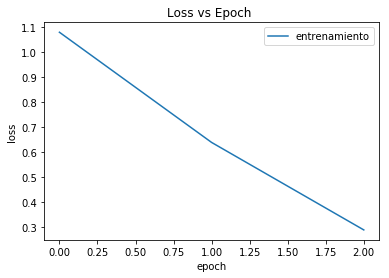

In [29]:
graficarError([history_f[0].history['loss']], ['entrenamiento'])

In [30]:
print("Loss: %f " %  scores_f[0])
print("Acc:  %f " % scores_f[1])

Loss: 0.181395 
Acc:  0.954576 


### g) Varı́e la dimensionalidad del embedding inicial y determine si aumenta o disminuye el error de clasificación. Comente.

In [31]:
embVector = range(16,49,4)
scores_all_g = []
history_all_g = []
time_all_g = []
for ev in embVector:
    print("Embedding Inicial: ",ev )
    scores_g, _, hist_g, time_g = create_model(ev,n_lemmas, num_maxSent,n_labels, X_train, Y_train, X_test, Y_test)
    
    history_all_g.append(hist_g[0].history['loss'])
    scores_all_g.append(scores_g)
    time_all_g.append(time_g)

('Embedding Inicial: ', 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 16)            323904    
_________________________________________________________________
lstm_2 (LSTM)                (None, 81, 100)           46800     
_________________________________________________________________
dense_2 (Dense)              (None, 81, 42)            4242      
Total params: 374,946
Trainable params: 374,946
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 28s 834us/step - loss: 1.1079 - acc: 0.7444 - val_loss: 0.7868 - val_acc: 0.7723
Epoch 2/3
33656/33656 [==============================] - 28s 822us/step - loss: 0.6966 - acc: 0.8113 - val_loss: 0.5402 - val_acc: 0.8437
Epoch 3/3
33656/33656 [=======================

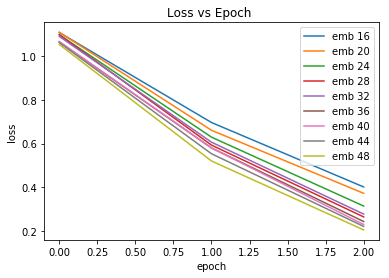

In [32]:
graficarError(map(lambda h: h,history_all_g), map(lambda e: "emb %d" % e, embVector))

** Comentario: ** Se observa en el gráfico que a medida que embedding aumenta, el error va disminuyendo. Con embedding=48 se obtienen mejores resultados. Se prueba con un tamaño de embedding mayor para verificar si sigue siendo opción aumentar el tamaño de embedding.

In [33]:
scores_g52, _, hist_g52, time_g52 = create_model(52,n_lemmas, num_maxSent,n_labels, X_train, Y_train, X_test, Y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 81, 52)            1052688   
_________________________________________________________________
lstm_11 (LSTM)               (None, 81, 100)           61200     
_________________________________________________________________
dense_11 (Dense)             (None, 81, 42)            4242      
Total params: 1,118,130
Trainable params: 1,118,130
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 29s 856us/step - loss: 1.0612 - acc: 0.7506 - val_loss: 0.7471 - val_acc: 0.7887
Epoch 2/3
33656/33656 [==============================] - 28s 824us/step - loss: 0.5664 - acc: 0.8458 - val_loss: 0.3670 - val_acc: 0.8979
Epoch 3/3
33656/33656 [==============================] - 28s 831us/ste

In [34]:
resultados_emb = []
resultados_emb = map(lambda h: h,history_all_g)
resultados_emb.append(hist_g52[0].history['loss'])

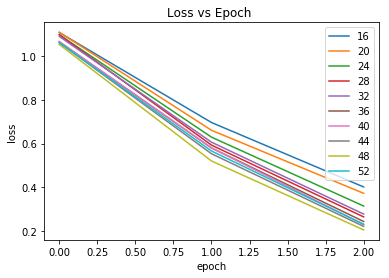

In [35]:
graficarError(resultados_emb, ("16", "20","24","28","32","36","40","44","48","52"))

** Comentarios:** Como se observa en el gráfico, al agregar la comparación con embedding = 52, su resultados es muy similar a embedding=44, por lo que no se sigue explorando distintos valores. Para los demás gráficos se consideran los resultados hasta embedding = 48.

In [36]:
import itertools
def scatterScoreEmbedding(_title, _ylabel, _embVector, _scores, _score_labels=None):
    
    markers = itertools.cycle(('o', '+', 'x', '*')) 

    if _score_labels is not None:
        showLegend = True
    else:
        showLegend = False
        _score_labels = ['']*len(_scores)
    
    for _s, _l in zip(_scores, _score_labels):
        _ = plt.scatter(_embVector, _s, label=_l, marker=markers.next())
        
    if showLegend:
        _ = plt.legend()
        
    _ = plt.title(_title)  
    _ = plt.xlabel("tam. embedding")
    _ = plt.ylabel(_ylabel)
    _ = plt.show()  

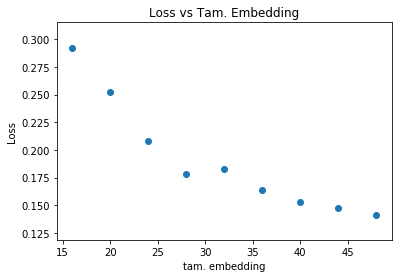

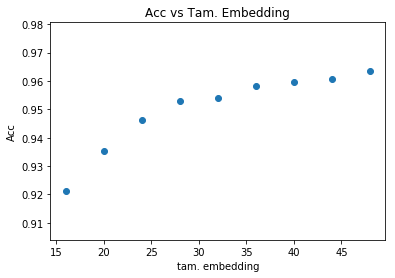

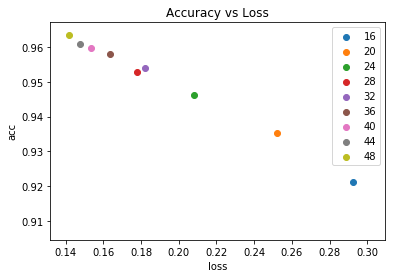

In [37]:
#scores_all_g
scores_loss_g = map(lambda s: s[0], scores_all_g)
scores_acc_g = map(lambda s: s[1], scores_all_g)

scatterScoreEmbedding("Loss vs Tam. Embedding", "Loss", embVector, [scores_loss_g])

scatterScoreEmbedding("Acc vs Tam. Embedding", "Acc", embVector, [scores_acc_g])

for loss_g, acc_g, emb in zip(scores_loss_g, scores_acc_g, embVector):
    ps = plt.scatter(loss_g, acc_g, label=emb)
_ = plt.title("Accuracy vs Loss")  
_ = plt.xlabel("loss")
_ = plt.ylabel("acc")    
_ = plt.legend()
_ =  plt.show()

** Comentarios: ** Como se observa en los gráficos, a medida que aumenta el tamaño de embedding disminuye el error y aumenta precisión. Los mejores resultados se obtienen con embedding = 48.

In [38]:
def g_bar(_data,_textX, _textY, _title, _valuesX):
    #posicion_x = np.arange(len(lag_values))
    _ = plt.bar(_valuesX, _data, align = "center")
    #_ = plt.xticks(posicion_x, lag_values)
    _ = plt.xlabel(_textX)
    _ = plt.ylabel(_textY)
    _ = plt.title(_title)
    #_ = plt.ylim(2.875, 3.0) solo para scores

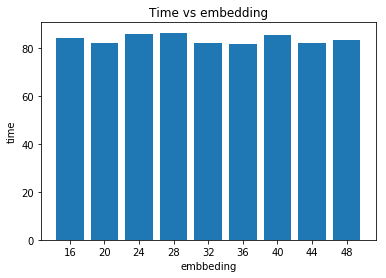

In [39]:

g_bar(time_all_g,"embbeding", "time", "Time vs embedding", map(lambda e: "%d" % e, embVector))

In [40]:
pd.DataFrame(time_all_g).describe()

,0
count,9.000000
mean,83.598722
std,1.745358
min,81.660350
25%,82.086672
50%,83.423995
75%,85.110702
max,86.264168


** Comentario:**  Como se observa en el gráfico y estadística descriptiva, los tiempos tienen valores muy similares, por lo que el tiempo de entrenamiento pareciera no verse impactado por el tamaño de embedding. 

### h) Use Dropout para entrenar la LSTM. ¿El Dropout mejora el desempeño de la red? Señale cuales podrı́an ser las causas del comportamiento observado.


Para comparar el desempeño con dropout, se va modificando el tamaño de embedding, al igual que la pregunta anterior, con el objetivo de tener un punto de comparación.

In [41]:
embVector = range(16,49,4)
scores_h = []
history_h = []
time_h = []
for ev in embVector:
    model_h = Sequential()
    model_h.add(Embedding(input_dim=n_lemmas, output_dim=ev, input_length=num_maxSent))
    model_h.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
    model_h.add(Dropout(0.2))
    model_h.add(Dense(n_labels, activation='softmax'))
    model_h.summary()
    model_h.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    start_time_h = time.time()
    history_h.append(model_h.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3, batch_size=128))
    end_time_h = time.time()
    time_h.append(end_time_h - start_time_h)
    scores_h.append(model_h.evaluate(X_test, Y_test, verbose=0))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 81, 16)            323904    
_________________________________________________________________
lstm_12 (LSTM)               (None, 81, 100)           46800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 81, 100)           0         
_________________________________________________________________
dense_12 (Dense)             (None, 81, 42)            4242      
Total params: 374,946
Trainable params: 374,946
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 28s 845us/step - loss: 1.1042 - acc: 0.7430 - val_loss: 0.7914 - val_acc: 0.7737
Epoch 2/3
33656/33656 [==============================] - 27s 809us/step - loss: 

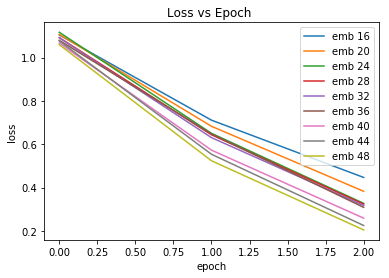

In [42]:
### Graficos
graficarError(map(lambda h: h.history['loss'],history_h), map(lambda e: "emb %d" % e, embVector))


** Comentarios:** Se observa que con dropout, se mantiene el desempeño de acuerdo al tamaño de embedding, siendo el mejor resultado con embedding=48. 

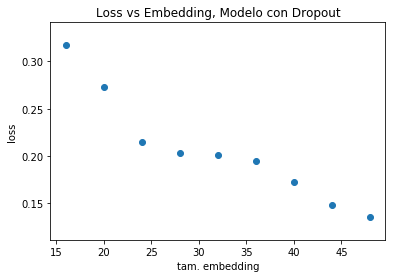

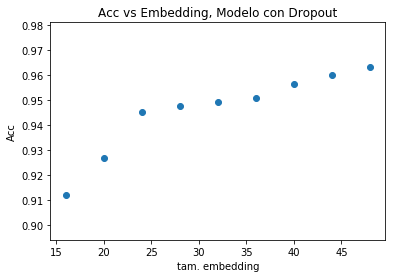

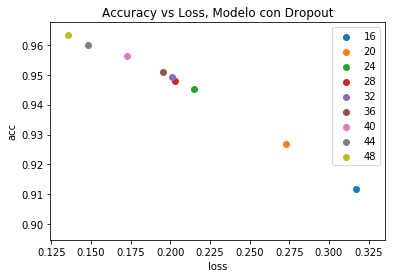

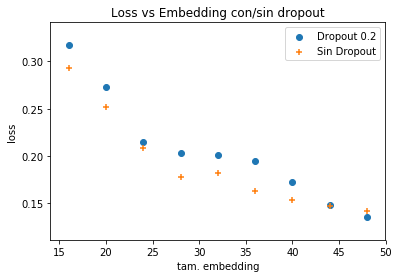

In [43]:
scores_loss_h = map(lambda s: s[0], scores_h)
scores_acc_h = map(lambda s: s[1], scores_h)

_ = scatterScoreEmbedding('Loss vs Embedding, Modelo con Dropout', 'loss', embVector, [scores_loss_h])
_ = scatterScoreEmbedding('Acc vs Embedding, Modelo con Dropout', 'Acc', embVector, [scores_acc_h])


for loss_h, acc_h, emb in zip(scores_loss_h, scores_acc_h, embVector):
    ps = plt.scatter(loss_h, acc_h, label=emb)
_ = plt.title("Accuracy vs Loss, Modelo con Dropout")  
_ = plt.xlabel("loss")
_ = plt.ylabel("acc")    
_ = plt.legend()
_ =  plt.show()

_ = scatterScoreEmbedding('Loss vs Embedding con/sin dropout', 'loss',
                          embVector, [scores_loss_h, scores_loss_g], ['Dropout 0.2', 'Sin Dropout'])


** Comentario** Se observa que con Dropout, a medida que aumenta el tamaño de embedding disminuye el error y aumenta precisión. El mejor resultado se obtiene con embedding = 48.

Al comparar los modelos con y sin dropout, se observa que con tamaño de embedding menor a 40, el modelo sin droput tiene mejor desempeño. Sin embargo con embedding=44 el comportamiento es casí identido, y con embedding=48 se obtiene mejor resultado con el modelo con dropout. Esto se puede deber a que cuando el embedding es mayor y al trabajar con distintas redes "adelgazadas" al utilizar dropout, va previniendo el overfitting y la coadaptación.
 

### i) Red Recurrente Bidireccional, utilizando el parámetro _merge mode_

**Enunciado**: Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen. Mejore la red definida en f) utilizando una red neuronal recurrente Bidireccional, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente cuál debiera ser la forma correcta de usar el parámetro *merge_mode* (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. ¿Mejora o empeora el desempeño? Analice.

In [44]:
## layer: Recurrent instance.
#merge_mode: Mode by which outputs of the forward and backward RNNs will be combined. 
#One of {'sum', 'mul', 'concat', 'ave', None}. If None, the outputs will not be combined, they will be returned as a list.
#https://keras.io/layers/wrappers/

from keras.layers import Bidirectional
embedding_vector = 32  ## Se utiliza 32 para tener punto de comparación con modelo f)

m_mode = ['sum', 'mul', 'concat', 'ave']
scores_i = []
time_i = []
history_i = []
for mm in m_mode:    
    print("Merge Mode: %s" % str(mm))
    model_i = Sequential()
    model_i.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=num_maxSent))
    layer_lstm = LSTM(units=100,return_sequences=True)
    model_i.add(Bidirectional(layer_lstm,merge_mode=mm))
    model_i.add(Dense(n_labels, activation='softmax'))
    model_i.summary()
    model_i.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    start_time_i = time.time()
    history_i.append(model_i.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3, batch_size=128))
    end_time_i = time.time()
    time_i.append(end_time_i - start_time_i)
    scores_i.append(model_i.evaluate(X_test, Y_test, verbose=0))


Merge Mode: sum
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 81, 32)            647808    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 81, 100)           106400    
_________________________________________________________________
dense_21 (Dense)             (None, 81, 42)            4242      
Total params: 758,450
Trainable params: 758,450
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 68s 2ms/step - loss: 0.9632 - acc: 0.7570 - val_loss: 0.7204 - val_acc: 0.7890
Epoch 2/3
33656/33656 [==============================] - 67s 2ms/step - loss: 0.5282 - acc: 0.8587 - val_loss: 0.2895 - val_acc: 0.9244
Epoch 3/3
33656/33656 [==============================] - 67s 2

### ¿Mejora o empeora el desempeño? Analice.

Para poder determinar cuál es la forma correcta de utilizar el parámetro _merge mode_ es que se entreno la red con las cuatro opciones. Verificando el valor del error, comparando los resultados con el modelo f) y tiempo de ejecución. Para todos los casos se utiliza embedding = 32 (que es el que tiene el modelo f), para tener una base de comparación.

Los resultados y comentarios se presentan a continuación.

[[0.963159590527426, 0.5282134564962244, 0.17480986008727412],
 [1.1804619917031958, 0.5122913857069666, 0.1967483306791087],
 [0.9742368511697984, 0.5292343471419763, 0.20191557227587625],
 [1.0262857628373032, 0.6683547209327567, 0.3303510334129313],
 [1.080693435705782, 0.6398455638102859, 0.28982451058338]]

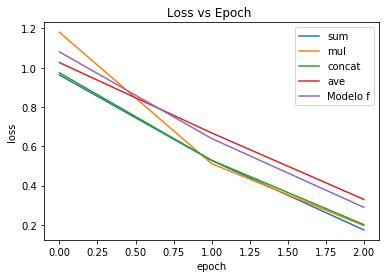

In [45]:
## Graficos
modelos = []
modelos = map(lambda h: h.history['loss'],history_i)
modelos.append(history_f[0].history['loss'])
modelos
graficarError(modelos, ("sum", "mul", "concat", "ave", "Modelo f"))

** Comentarios**
* Con respecto a los parámetros, se observa que utilizando el modo concat, el output shape  en la capa bidireccional queda de tamaño doble (none, 81, 200), con respecto a los otros modos que tienen la forma (none, 81, 100). De igual forma genera el doble de parámetros en la capa dense, que con los otros modos.

* De acuerdo al gráfico de loss, se observa que con modo _sum_, se obtiene el mejor resultado de convergencia. Apesar de obtener resultados muy similares  con *mul* y * concat*. El peor resultado es con *average*.

* El modelo f, con respecto a convergencia, es peor que los modos _sum_, _concat_ y _mul_, y mejor que con el modo _ave_. 

De acuerdo a estos resultados, es conveniente utilizar el modo _sum_ para combinar las salidas de forward y backward en la RNN.

In [46]:
time_i
modelos_time = list(time_i)
modelos_time.append(time_f)
modelos_time

[202.9467978477478, 202.57078409194946, 196.66707396507263, 201.94291186332703]

[202.9467978477478,
 202.57078409194946,
 196.66707396507263,
 201.94291186332703,
 82.45816898345947]

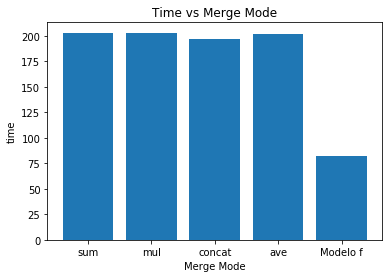

In [47]:
g_bar(modelos_time,"Merge Mode", "time", "Time vs Merge Mode", ["sum", "mul", "concat", "ave", "Modelo f"] )

** Comentarios ** Con respecto al tiempo de ejecución, no se observan mayores diferencias en los tiempos para cada merge_mode. Sin embargo el tiempo del modelo f) fue la mitad que para las versiones bidireccionales.

### j) Para modelo h, predicción para *pos tager*

**Enunciado** Utilice alguna de las red entrenadas, ojalá una con buen desempeño y muestre las predicciones, el *pos tager*, sobre algún ejemplo de pruebas, comente. Para entender qué son los símbolos *Part of speech tags* visite el siguiente link: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html 

Se utiliza el modelo con dropout con tamaño de embedding=48

In [48]:
i = 100
p = model_h.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("Lemma", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(idx2lemma[w],idx2lab[pred]))

Lemma          : Pred
fight          : POS
between        : IN
the            : DT
popular        : JJ
movement       : NN
for            : IN
the            : DT
liber          : NNP
of             : IN
angola         : NNP
(              : WP
mpla           : NNP
)              : VB
,              : ,
led            : VBD
by             : IN
jose           : NNP
eduardo        : NNP
dos            : NNP
santo          : NNP
,              : ,
and            : CC
the            : DT
nation         : NN
union          : NNP
for            : IN
the            : DT
total          : NN
independ       : NN
of             : IN
angola         : NNP
(              : WP
unita          : NNP
)              : VBG
,              : ,
led            : VBD
by             : IN
jona           : NNP
savimbi        : NNS
,              : ,
follow         : VBG
independ       : JJ
from           : IN
portug         : NNP
in             : IN
1975           : CD
.              : .
_ENDSEN_       : _ENDTAG_

** Comentarios** De acuerdo a la predicción, se observa que la red logra predecir de forma correcta el tag, de acuerdo a la descripción descrita en el link.
Sin embargo existen algunas clasificaciones que llaman la atención, como es el caso de:
* ( : que es clafisicado como WP (pronombre con wh) y podría ser SYM (Símbolo).
* ) : clasificado como VB (Verbo, forma base) y VBG (Verbo, gerundio o participio presente). Posible clasificación SYM
* , : es clasificado como , y también podría ser SYM
* . : clsificado como . y también podría ser SYM
* dos/union: Clasificado como NNP (nombre propio, singular), y no cumple ya que no nombra de forma única e irreptible como son los nombres propios.

**Enunciado ** Ahora utilizaremos el mismo dataset para realizar una aplicación mas conocida hoy en día que es el autocompletar texto, esto es, predecir la siguiente palabra de una sentencia basada en las palabras anteriores de la misma, por lo que la red que utilizaremos es del tipo *many to one*.  

Debido a lo extenso del vocabulario es bastante complejo hacer un modelo que prediga una palabra dentro de las millones que pueden haber, por lo que, trabajaremos a nivel de carácter, en donde las posibilidades (posibles clases) son mucho menores

### k)  Cargando las palabras del dataset, creando corpus y codificación de caracteres a núemros.
 
**Enunciado:**Carge las palabras del dataset ¿Por qué no los *lemmas*? y cree el corpus con el cual se trabajará, además de crear la codificación de caracteres a números. Esto se presenta en el código a continuación además de crear la estrucutura de los datos con los que se va a trabajar (sub sentencias del corpus original). Utilice el tamaño del *corpus* que le acomode a la memoria de su computador.


### ¿Por qué no los *lemmas*?

Considerando que se trabajará para predecir una palabra, caracter por caracter, para autocompletar textos es necesario tener la palabra completa y no sólo la raíz de la palabra, ya que la plabra completa da el significado correcto al texto. Considerando que distintas palabras pueden tener la misma raíz.

### Creación de Corpus, codificación de caracteres a números.

In [49]:
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)} # dic caracteres y numeros ej {'!': 2,}
indices_char = {i: c for i, c in enumerate(chars)} # de la forma {2: '!'}
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.5) #solo un 30% del corpus
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences)) ## datos con los que se trabajará

('total chars:', 72)
('nb sequences:', 606744)


In [87]:
sentences[0:10]

['*thousands of demonstrators have marched ',
 '*ands of demonstrators have marched throu',
 '*of demonstrators have marched through lo',
 '*monstrators have marched through london ',
 '*rators have marched through london to pr',
 '*s have marched through london to protest',
 '*e marched through london to protest the ',
 '*ched through london to protest the war i',
 '*through london to protest the war in ira',
 '*gh london to protest the war in iraq and']

### l)  Procesar las sentencias para tenerlas en numeros que van a representar los caracteres. Padding al comienzo de la sentencia. Transformación de etiquetas a *one hot vector*. Red: red modelo f), capa emebedding, red GRU y capa de clasificación.

**Enunciado** Procese las sentencias para así tenerlas codificadas en números que van a representar los carácteres, tal cual se realizó en c) con los *lemmas*, lo mismo para las etiquetas. Además de esto deberá realizar el *padding* correspondiente al comienzo de la sentencia, esto es para que la red aprenda cuando venga una frase mas corta de lo entrenado, este símbolo siignificará que no hay información. Transforme las etiquetas a *one hot vector* como se realizó en c) y defina la red similar a la presentada en f), con un *embedding* seguido de una capa recurrente GRU y la capa de clasificación. Aprovechese de la implementación más rápida de GRU respaldada por __[CuDNN](https://developer.nvidia.com/cudnn)__, una librería de CUDA (NVIDIA) para *Deep Neural Network*. 



In [50]:
#Se agrega caracter para utilizar en el padding

print("Largo %d antes de agregar caracter " % len(char_indices))
## Se agrega el  caracter  | 
char_indices.update({'|':len(char_indices)})
indices_char.update({len(char_indices):'|'})

#key de |
print("Indice de caracter |: %d" % char_indices['|']) #Indices de 0 a len(char_indices)-1

Largo 72 antes de agregar caracter 
Indice de caracter |: 72


In [51]:
num_maxChar = len(char_indices)
num_maxIndex = len(indices_char)
print("Largo de arreglo de caracteres %d " % num_maxChar )
print("Largo de arreglo de indices %d" % num_maxIndex )

Largo de arreglo de caracteres 73 
Largo de arreglo de indices 73


In [52]:
# Codificando caracter por caracter
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences] 
dataY = [char_indices[char] for char in next_chars]

In [53]:
## Agrega el padding a sentencias
X = sequence.pad_sequences(dataX,maxlen=maxlen ,padding='pre',value=char_indices['|'])

In [55]:
## Transforma Y a one hotvector
Y = np.asarray([to_categorical(i, num_classes=num_maxIndex) for i in dataY])

In [56]:
## Creando conjunto de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=22)

In [57]:
## Dimensiones de los conjunto de entrenamiento y prueba
print("Dimension datos de entrenamiento - X_train %s" % str(X_train.shape))
print("Dimension datos de entrenamiento - Y_train %s" % str(Y_train.shape))
print("Dimension datos de prueba        - X_test  %s" % str(X_test.shape))
print("Dimension datos de prueba        - Y_test  %s" % str(Y_test.shape))

Dimension datos de entrenamiento - X_train (424720, 40)
Dimension datos de entrenamiento - Y_train (424720, 73)
Dimension datos de prueba        - X_test  (182024, 40)
Dimension datos de prueba        - Y_test  (182024, 73)


In [58]:
history_l = []
time_l = []
scores_l = []
embedding_vector = 16
model_l = Sequential()
model_l.add(Embedding(input_dim=num_maxChar, output_dim=embedding_vector, input_length=maxlen))#
model_l.add(CuDNNGRU(units=512,return_sequences=False)) #or GRU
model_l.add(Dropout(0.2))
model_l.add(Dense(num_maxChar, activation='softmax'))
model_l.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_l.summary()
start_time_l = time.time()
history_l.append(model_l.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3, batch_size=128))
end_time_l = time.time()
time_l.append(end_time_l - start_time_l)
scores_l.append(model_l.evaluate(X_test, Y_test, verbose=0))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 40, 16)            1168      
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 512)               814080    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 73)                37449     
Total params: 852,697
Trainable params: 852,697
Non-trainable params: 0
_________________________________________________________________
Train on 424720 samples, validate on 182024 samples
Epoch 1/3
424720/424720 [==============================] - 43s 100us/step - loss: 2.1298 - acc: 0.3783 - val_loss: 1.6752 - val_acc: 0.5079
Epoch 2/3
424720/424720 [==============================] - 40s 95us/step - l

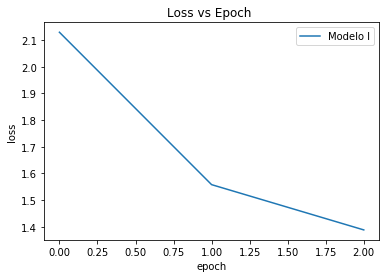

In [59]:
graficarError([history_l[0].history['loss']],['Modelo l'])

In [60]:
print("Tiempo de Entrenamiento %f" % time_l[0])

Tiempo de Entrenamiento 124.073103


In [61]:
print("Loss Modelo:     %f" % scores_l[0][0])
print("Accuracy Modelo: %f" % scores_l[0][1])

Loss Modelo:     1.350210
Accuracy Modelo: 0.600926


### m) Entrenando la red y verificando por epochs la tarea de autocompletar.

**Enunciado:** Entrene la red con las funciones que se presentan a continuación que mostrarán el cómo va la tarea de autocompletar texto en cada *epoch*, generando una sentencia completa de 400 carácteres *aleatoriamente* a partir de una semilla *random*. Entrene solo durante 25 *epochs*, a los 15 ya debería comenzar a generar palabras y sonar mas coherente.

In [62]:
def predict_next_char(model_l, sentence, divverificandoersity=1.0):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen,padding='pre',value=char_indices[null_character])
    preds = model_l.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(char_indices), p=preds)
    return indices_char[next_index]


def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model_l, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

In [63]:
X_test.shape
Y_test.shape

(182024, 40)

(182024, 73)

In [64]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model_l.fit(X_test, Y_test,batch_size=256,epochs=25, callbacks=[print_callback])

Epoch 1/25
182024/182024 [==============================] - 11s 59us/step - loss: 1.3728 - acc: 0.5958

----- Generating text after Epoch: 0
----- Generating with seed: "the national assembly . specific plans f"
the national assembly . specific plans floud missile separatoss haters prime minister sgacks and deplaced huety shows that passest in a u.s. demonrtord skidlly hilly have part in part of their bombings from the grrus some 20 percent of stathing feceral maushaating news caction quotes prope countries are she time proplum of india 's companies at a clud for the chousted british orginist aating a qucrorts released a dequarand and cause of Epoch 2/25
182024/182024 [==============================] - 11s 59us/step - loss: 1.2892 - acc: 0.6160

----- Generating text after Epoch: 1
----- Generating with seed: "elopment . a netherlands court has opene"
elopment . a netherlands court has opened in talabane-detacks on birb placeed the bushime transitive spread as " they held to east israe

** Comentarios ** Se obsrerva que a medida que aumento el número de epoch se tiene, en cada texto generado más palabras coherentes, y  ya sobre el epoch 14, las palabras empiezan a estar de acuerdo a un tema espcífico.

En el último epoch, a pesar de que no se entiende en un 100% el texto, existen en su gran mayoría palabras relacionadas y con sentido.

### n) Verificando la calidad de la red entrenada. Predicción sobre una semilla inicial.

**Enunciado:** Verifique la calidad de la red entrenada, cargando el modelo si es que lo guardó o directamente, entregando una predicción sobre una semilla inicial que usted entregue. Observe y comente cualitativamente sobre qué pasa cuando la predicción del siguiente carácter fuese de manera determinista, tomando el máximo valor de entre las predicciones.

In [65]:
sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model_l, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: "it is "
it is part member 's capital to proces , which say and euri has ovines have andornouschae , as a party iasterrod has can doors of parria . an appair , has proving north and after lated jaman said on the remoress, vostile , and shorts , a foreigah of isjues falled kay more that ulane . shi'topan , saying hester has activion , sign says their and boad in the securi group . a talks says in 200 sjure has ai

In [66]:
sentence = "the nations wait for "

print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model_l, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: "the nations wait for "
the nations wait for released whithered ex ane of extraint , with authority and president mahmoud abdas are nation . he will stapp the community of this month 's by the suspected lust setan , south aria . a report issued eghitier the 2002 peace proces and issue is alowather detained near fighting in him . in part . but has offices are between afghan issue in takhered harrive neart to return to the technol mebborand da

** Comentarios** 

Con la primera sentencia, se verifica que no se encuentra mayor relación, a pesar de que existen palabras con sentido. Sin embargo con la segunda frase el texto tiene mucho sentido y al modificar algunas palabras del texto generado podría quedar como una "noticia". El modelo que se utliza tiene accuracy de 0.600926, por lo que con un modelo que tenga mejor accuracy se podrían mejorar mucho más los resultados.